In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn import metrics
from sklearn.decomposition import PCA
import tabulate
import itertools
import igraph as ig
import matplotlib.patches as mpatches
from sklearn.neighbors import kneighbors_graph
from scipy.spatial.distance import pdist, squareform
import leidenalg as la

from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import umap
from importlib import reload
from scipy import stats
import matplotlib.image as mpimg
import goatools
from goatools.anno.gaf_reader import GafReader
import Bio.UniProt.GOA as GOA
import gget

# locals
import utils as ut
reload(ut)

2022-12-08 15:13:43.371051: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 15:13:43.481791: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2022-12-08 15:13:43.481812: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-08 15:13:43.507421: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-08 15:13:44.3343

<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/utils.py'>

In [2]:
# load cluster assignments
cdf = pd.read_csv("clusterAssignments.csv")
cid = {}

for key in cdf['key'].unique():
    t = cdf[cdf['key'] == key]
    cid[key] = t
    
print('done')

done


In [3]:
dirPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/"

adata = {}

for f in os.listdir(dirPath):
    
    if f.endswith('.h5ad'):
        key = f.split(".")[0]
        fullPath = f"{dirPath}{f}"
        data = sc.read(fullPath)
        adata[key] = data
    
print("done")

done


In [4]:
keys = ['ND', 'HFD8', 'HFD14']
ctypes = ['Macrophages', 'Monocytes']
ctypes = ['Macrophages']

res = []
refs = []

for key in keys:
    data = adata[key]
    
    # get the run key
    allKeys = list(data.obs.keys() )
    allKeys.remove('n_genes')
    runKey = allKeys[0]
    
    clusterIds = data.obs[runKey].astype(int) + 1  # note that these are zero-indexed!
    # get number of clusterss
    k = data.obs[runKey].nunique() + 1
    colorlist = ut.ncolor(k, cmap='Spectral')
    df = data.to_df()
    
    # get all clusters for the cell type
    cellTypes = cid[key]
    
    for ctype in ctypes:
        cellTypeIds = cellTypes[cellTypes['cellType'] == ctype]['clusterId'].to_numpy()
        mask = clusterIds.isin(cellTypeIds)
        
        # extract cells
        cells = df[mask]
        print(cells.shape)
        
        # extract cell ids
        r = pd.DataFrame(cells.index)
        r.columns = ['CellId']
        r['key'] = key
        r['ctype'] = ctype
        
        res.append(cells)
        refs.append(r)

        
res = pd.concat(res, ignore_index=True)
print(f"{res.shape=}")
refs = pd.concat(refs, ignore_index=True)
print(f"{refs.shape=}")

print(refs['ctype'].value_counts(normalize=True))
print()
res.head()

(359, 12490)
(2188, 13768)
(3884, 13479)
res.shape=(6431, 14205)
refs.shape=(6431, 3)
Macrophages    1.0
Name: ctype, dtype: float64



MRPL15    LYPLA1     TCEA1   ATP6V1H    RB1CC1  4732440D04RIK  PCMTD1  \
0  0.000000  0.000000  1.540236  0.000000  1.540236            0.0     0.0   
1  0.000000  0.000000  0.000000  0.000000  1.167320            0.0     0.0   
2  0.751568  0.000000  0.000000  0.751568  0.000000            0.0     0.0   
3  0.000000  0.000000  0.000000  0.000000  0.619184            0.0     0.0   
4  0.000000  1.463523  1.463523  0.000000  0.000000            0.0     0.0   

   RRS1  MYBL1  VCPIP1  ...  KATNAL2  SIGLEC15  BBS1  PELI3  CST6  GM10353  \
0   0.0    0.0     0.0  ...      NaN       NaN   NaN    NaN   NaN      NaN   
1   0.0    0.0     0.0  ...      NaN       NaN   NaN    NaN   NaN      NaN   
2   0.0    0.0     0.0  ...      NaN       NaN   NaN    NaN   NaN      NaN   
3   0.0    0.0     0.0  ...      NaN       NaN   NaN    NaN   NaN      NaN   
4   0.0    0.0     0.0  ...      NaN       NaN   NaN    NaN   NaN      NaN   

   SCGB1A1  MS4A2  LIPN  SLIT1  
0      NaN    NaN   NaN    NaN  
1      NaN    NaN   NaN    NaN  
2      NaN    NaN   NaN    NaN  
3      NaN    NaN   NaN    NaN  
4      NaN    NaN   NaN    NaN  

[5 rows x 14205 columns]

In [5]:
"""create a low-dimensional embedding for visualization """
X = res.fillna(0)
totalG = X.shape[1]

# remove low variance genes
stdT = 0.1
geneStd = X.std(axis=0)
mask = geneStd < stdT
X = X[X.columns[~mask]]
g = X.shape[1]
print(f"Removed {totalG - g} Genes with STD < {stdT}")


# plotting params
n_components = 2 # should always be 2
n_neighbors = 11
min_dist = 0.3

umap_reducer = umap.UMAP(n_components=n_components,
                         n_neighbors=n_neighbors,
                         min_dist=min_dist)

embedding = umap_reducer.fit_transform(X) # we need embedding by cell
embedding = pd.DataFrame(embedding)
embedding.columns = ['x', 'y']
embedding.head()

Removed 3412 Genes with STD < 0.1


x         y
0 -0.268444  6.488341
1  0.490509  6.144978
2  2.892116  2.997078
3  3.173228  3.169834
4 -0.900066  6.994492

Text(0.5, 1.0, 'Macrophages')

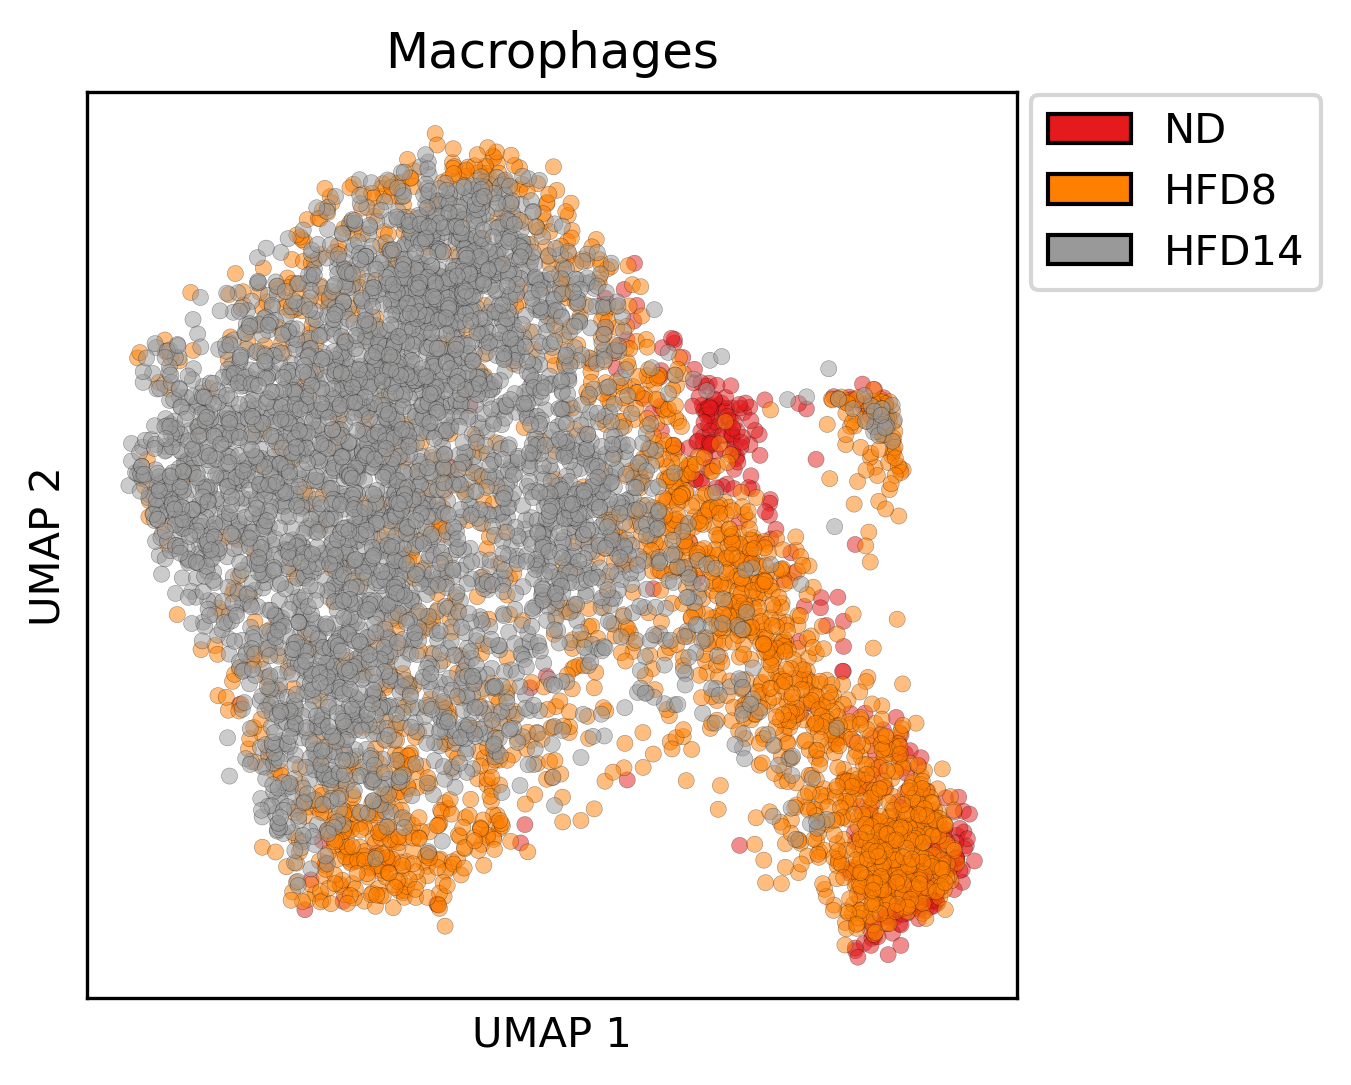

In [26]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 4, 4

"""add color information """

colorBy = 'key'
cmap = 'Set1'

colors = ut.ncolor(refs[colorBy].nunique(), cmap=cmap)
colors = dict(zip(refs[colorBy].unique(), colors))

handles = []

for label, color in colors.items():
    handle = mpatches.Patch(color=color, 
                            ec='k', 
                            label=f"{label}")
    
    handles.append(handle)
    
refs[f'color'] = refs[colorBy].map(colors)


plt.scatter(embedding['x'],
            embedding['y'], 
            marker=".",
            s=60,
            edgecolor='k',
            lw=0.1,
            c=refs[f'color'].to_list(),
            alpha=0.5)

plt.legend(handles=handles, bbox_to_anchor=(1.35, 1.02))
_ = plt.xticks([])
_ = plt.yticks([])

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title(f"{ctype}")

In [7]:
# break

In [60]:
def getDistanceMatrix(X, r=15, metric='euclidean', returnExp=True):
    """A function to compute pairwise distances from scRNA data """
    X = X.fillna(0).to_numpy()
    
    # compute the PCA 
    pca = PCA(n_components=r)
    pcaModel = pca.fit(X)
    Xpca = pca.fit_transform(X)
    
    # compute pairwise similarity
    A = metrics.pairwise_distances(Xpca, metric=metric)
    
    if returnExp:
        exVar = pcaModel.explained_variance_
        xp = [x/exVar.sum() for x in exVar]
        cumXp = np.cumsum(xp)
        
        return A, cumXp
    else:
        return A

In [71]:
# t = 0.8
# rRange = np.linspace(5, 100, 50).astype(int)

# result = []

# for r in rRange:
#     A, ex = getDistanceMatrix(res.fillna(0), r=r)
#     huer = np.min(np.argwhere(ex >= t)) + 1 
    
#     row = {
#         "nPCA" : r,
#         "First" : ex[0],
#         f"Hueristic" : huer
#     }
#     result.append(row)
    
# result = pd.DataFrame(result)
# result.head()

# plt.scatter(result['nPCA'], 
#             result['Hueristic'])

KeyboardInterrupt: 

12

(6431, 6431)


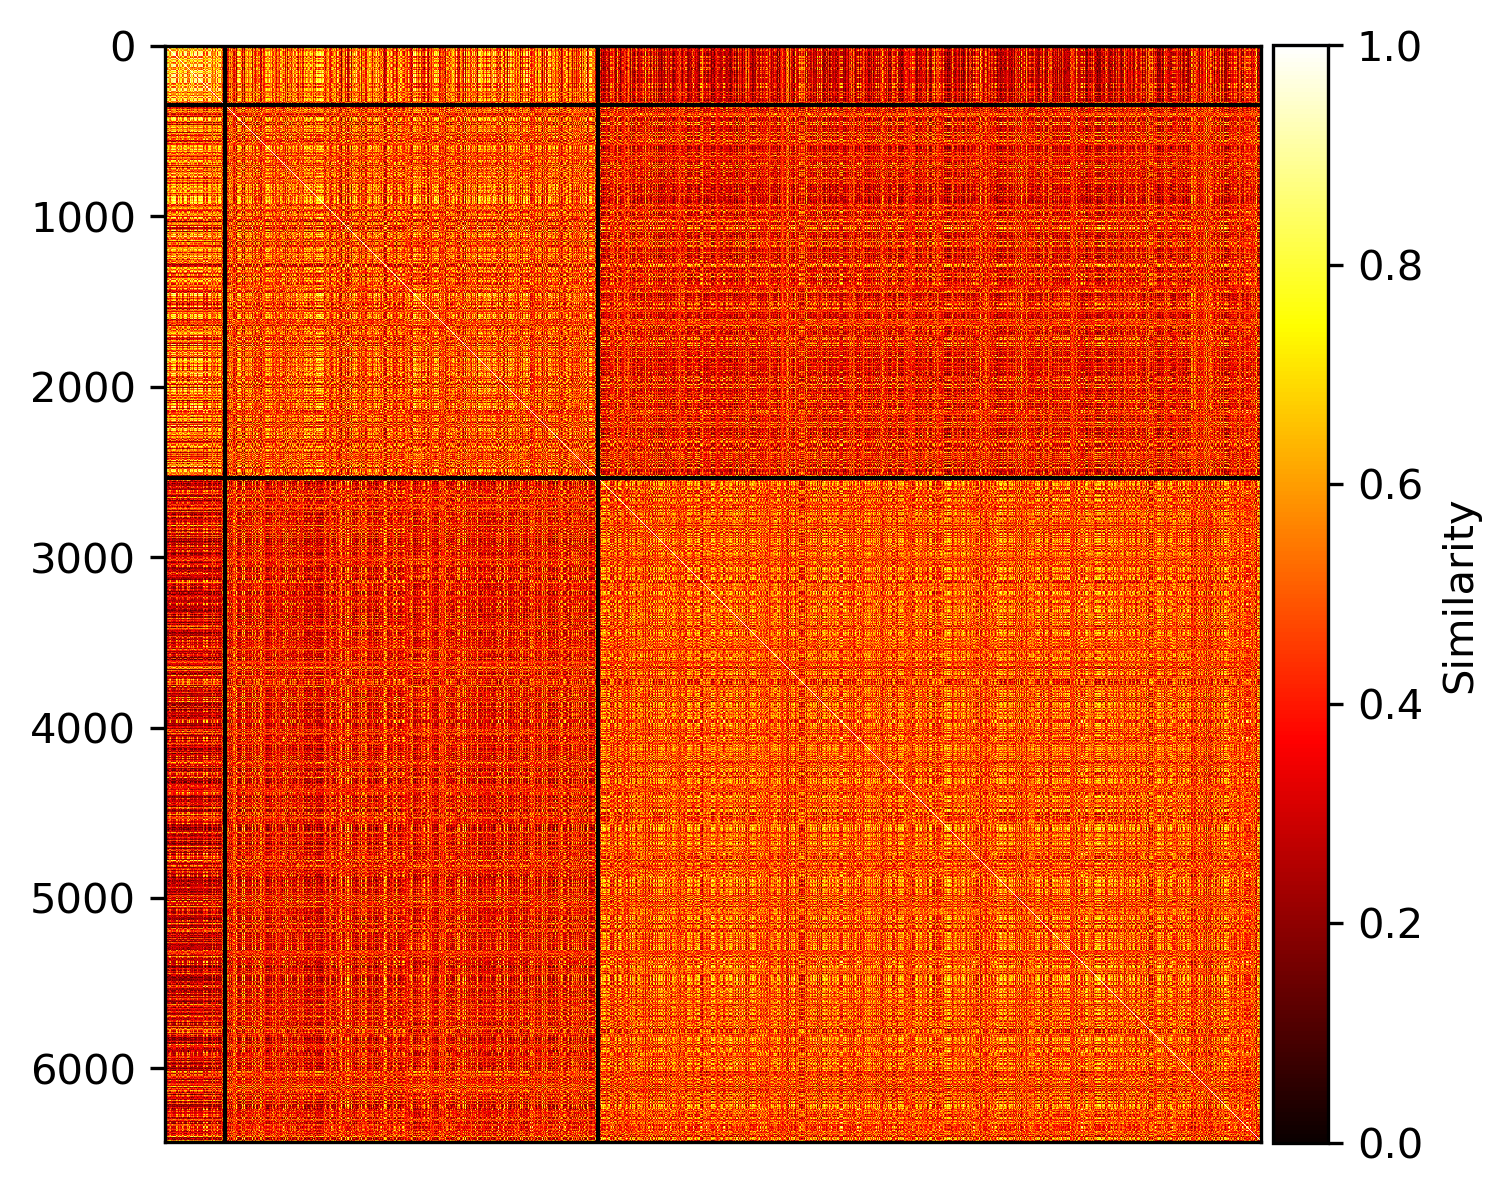

In [41]:
"""
Construct the distance matrix 
"""
metric='correlation'
r = 100
X = res.fillna(0)
        
A = getDistanceMatrix(X, r=r, metric=metric)
print(A.shape)

Ahat = A.copy()
Ahat *= 1.0/Ahat.max() 
Ahat = 1 - Ahat # convert distance to similarity

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 5, 5

linc = "k"
lw = 1

plt.matshow(Ahat, cmap='hot')
_ = plt.xticks([])
plt.colorbar(fraction=0.0472, pad=0.01, label='Similarity')

buff = 10
boundaries = [359-buff, 2188+359-buff]
for b in boundaries:
    plt.axvline(x=b, c=linc, lw=lw)
    plt.axhline(y=b, c=linc, lw=lw)

# for 

# lastType = 'Macrophages'

# labels = []
# ctL = []

# for ct in refs['ctype']:
#     if ct == lastType:
#         labels.append(0)
#     else:
#         ctL.append(lastType)
#         labels.append(1)
#         lastType = ct
        
# inx = np.nonzero(labels)[0]
# print(ctL)
# print(inx)

# locs = []

# lastInx = 0
# for i in inx:
#     plt.axvline(x=i, c=linc, lw=lw)
#     plt.axhline(y=i, c=linc, lw=lw)
    
#     endRange = ((i - lastInx) / 2) + lastInx
#     locs.append(endRange)
#     lastInx = i
    
# endRange = ((A.shape[0] - lastInx) / 2) + lastInx
# locs.append(endRange)

# plotLabel = ["ND Macrophages",
#              "ND Monocytes",
#              "HFD8 Macrophages",
#              "HFD8 Monocytes",
#              "HFD14 Macrophages",
#              "HFD14 Monocytes"]

# _ = plt.yticks(locs, plotLabel) 

0.9984219264181936


NameError: name 'inx' is not defined

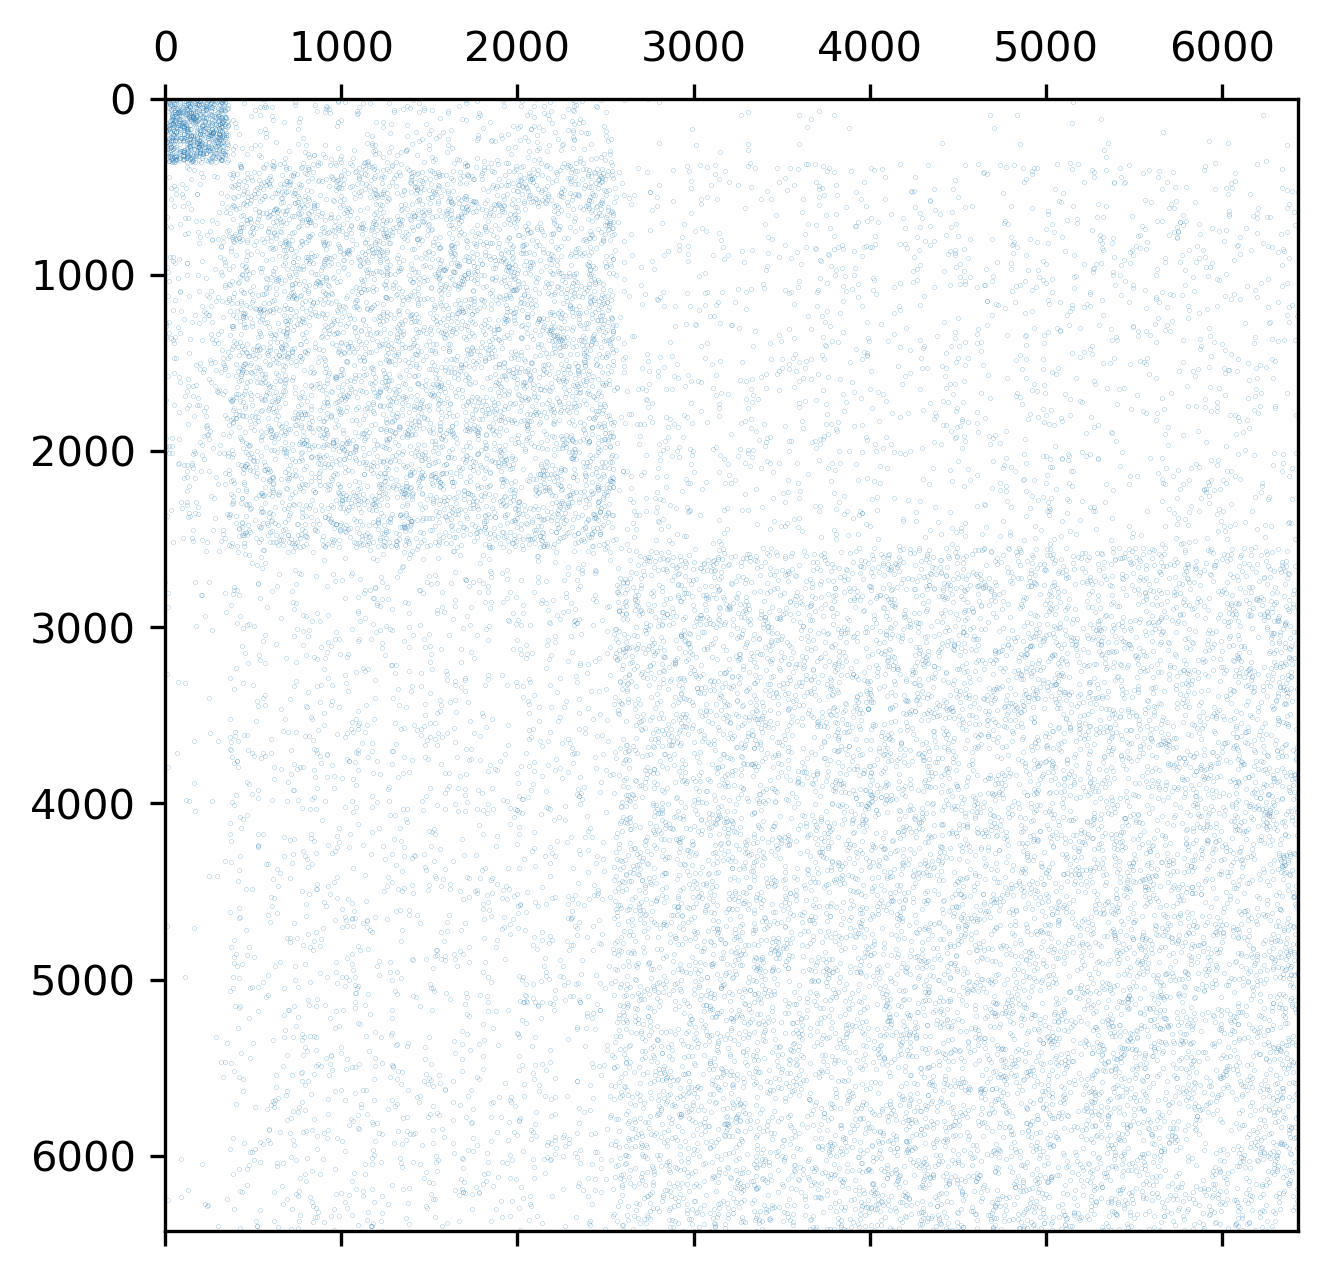

In [10]:
""" Construct the KNN graph"""

k = 3
knn = kneighbors_graph(A, k)
x, y = np.nonzero(knn.todense())
Aknn = np.zeros(Ahat.shape)

Aknn[x, y] = Ahat[x, y]
print(Aknn.max())
plt.spy(Aknn, 
        marker=".",
        markersize=0.1)


lastInx = 0
for i in inx:
    plt.axvline(x=i, c=linc, lw=lw)
    plt.axhline(y=i, c=linc, lw=lw)
    
    endRange = ((i - lastInx) / 2) + lastInx
    lastInx = i
    
plotLabel = ["ND Macrophages",
             "ND Monocytes",
             "HFD8 Macrophages",
             "HFD8 Monocytes",
             "HFD14 Macrophages",
             "HFD14 Monocytes",
         ]


_ = plt.yticks(locs, plotLabel) 
_ = plt.xticks([])

In [ ]:
""" recluster the cells using spectral """
k = 9
spect = SpectralClustering(n_clusters=k,
                           # affinity='precomputed_nearest_neighbors',
                           affinity='precomputed',
                           assign_labels='discretize',
                           random_state=0).fit(Aknn)

refs['Spectral'] = spect.labels_
print(refs['Spectral'].value_counts())

plt.scatter(embedding['x'],
            embedding['y'], 
            marker=".",
            s=40,
            edgecolor='k',
            lw=0.1,
            cmap='Spectral',
            c=refs['Spectral'].to_list(),
            alpha=0.4)

plt.legend()

In [ ]:
for cid in refs['Spectral'].unique():
        cluster = refs[refs['Spectral'] == cid]
        print(f"==== {cid} n={len(cluster)}===")
        print(cluster['ctype'].value_counts(normalize=True))
        print()
        print(cluster['key'].value_counts(normalize=True))
        print()

In [ ]:
"""Leiden clustering """
sources, targets = Aknn.nonzero()
weights = Aknn[sources, targets]
if isinstance(weights, np.matrix):
    weights = weights.A1
g = ig.Graph(directed=False)
g.add_vertices(Aknn.shape[0])  # this adds adjacency.shape[0] vertices
g.add_edges(list(zip(sources, targets)))
g.es['weight'] = weights

weights = np.array(g.es['weight']).astype(np.float64)
resolution_parameter = 0.8

partition = la.find_partition(g, 
                              la.RBConfigurationVertexPartition, 
                              weights=weights, 
                              resolution_parameter=resolution_parameter);

groups = np.array(partition.membership)
print(np.std(groups))
print(groups)

""" recluster the cells """

plt.scatter(embedding['x'],
            embedding['y'], 
            marker=".",
            s=40,
            edgecolor='k',
            lw=0.1,
            cmap='Spectral',
            c=groups,
            alpha=0.4)

In [ ]:
break

In [ ]:
# Ahat = A.copy()
# Ahat *= 1.0/Ahat.max() 

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 5, 5


# plt.matshow(Ahat, cmap='hot')
# _ = plt.xticks([])
# _ = plt.yticks([])
# plt.colorbar(fraction=0.0472, pad=0.01, label='Distance')
# plt.xlabel("Cells")
# plt.ylabel("Cells")

In [ ]:
# def getA(X, r, metric='euclidean'):
#     """A function to get the distance matrix A.
#     Expected a centered data matrix"""
    
#     Xc = X.fillna(0).apply(lambda x: x-x.mean())
#     Xc = Xc.to_numpy()
    
#     # SVD
#     u, s, v = np.linalg.svd(Xc)
    
#     # construct P
#     P = u[:, 0:r]
    
#     # build distance matrix
#     return squareform(pdist(P, metric=metric))
    
    
# A = getA(res, r=15)
# plt.matshow(A)